## Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

### Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

# 1. Preparation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

from catboost import CatBoostRegressor

In [2]:
data = pd.read_csv("./taxi.csv")
data['datetime'] = pd.to_datetime(data['datetime'])
data

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


In [3]:
data.set_index('datetime', inplace=True)
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null datetime64[ns]
num_orders    26496 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [4]:
data.index.is_monotonic

True

/Users/gleb/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


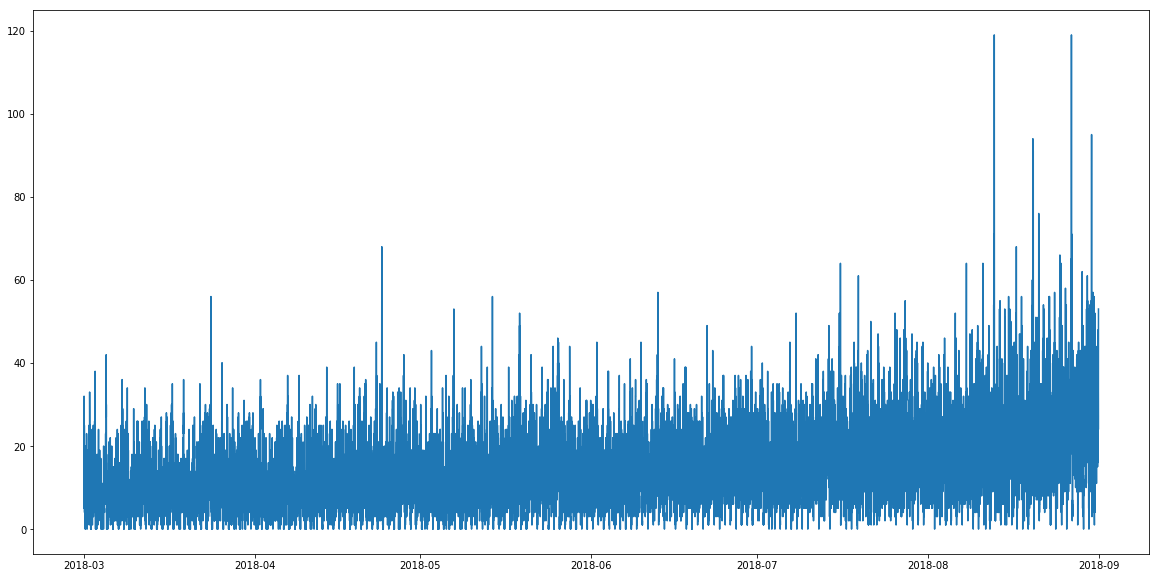

In [5]:
plt.figure(figsize=(20,10))
plt.plot(data)

In [6]:
new_data = data.copy()
new_data = new_data.resample('1H').mean()
new_data

,num_orders
datetime,
2018-03-01 00:00:00,20.666667
2018-03-01 01:00:00,14.166667
2018-03-01 02:00:00,11.833333
2018-03-01 03:00:00,11.000000
2018-03-01 04:00:00,7.166667
...,...
2018-08-31 19:00:00,22.666667
2018-08-31 20:00:00,25.666667
2018-08-31 21:00:00,26.500000


In [7]:
new_data['dayofweek'] = new_data.index.dayofweek
new_data['hour'] = new_data.index.hour
new_data['month'] = new_data.index.month
new_data

,num_orders,dayofweek,hour,month
datetime,,,,
2018-03-01 00:00:00,20.666667,3,0,3
2018-03-01 01:00:00,14.166667,3,1,3
2018-03-01 02:00:00,11.833333,3,2,3
2018-03-01 03:00:00,11.000000,3,3,3
2018-03-01 04:00:00,7.166667,3,4,3
...,...,...,...,...
2018-08-31 19:00:00,22.666667,4,19,8
2018-08-31 20:00:00,25.666667,4,20,8
2018-08-31 21:00:00,26.500000,4,21,8


# 2. Analysis

([<matplotlib.axis.XTick at 0x7fbdb0e7e8d0>,
 <a list of 24 Text xticklabel objects>)

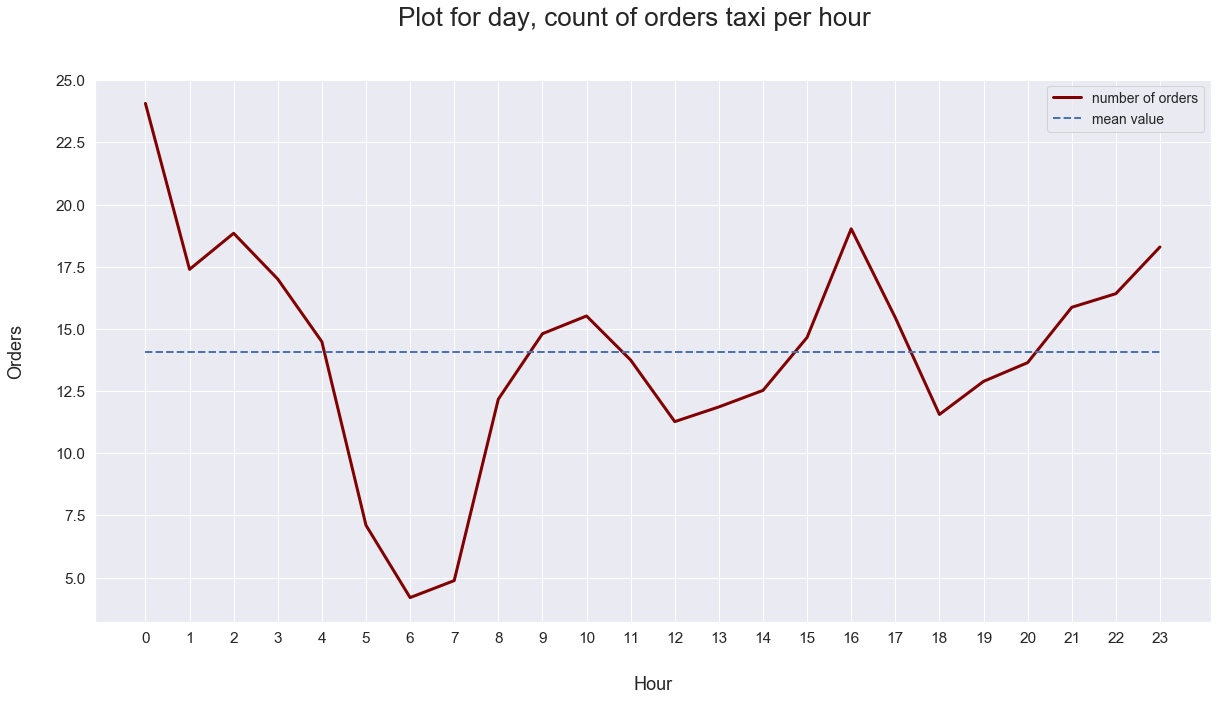

In [8]:
sns.set(font_scale=1.4)

fig = plt.figure(figsize=(20,10))
plt.plot(new_data.pivot_table(index=['hour'], aggfunc='mean', values=['num_orders']), linewidth=3, color='maroon')
plt.plot(range(0, 24, 1), np.ones(24) * new_data.pivot_table(index=['hour'], aggfunc='mean', values=['num_orders']).mean()[0], linewidth=2, linestyle='dashed')
fig.suptitle("Plot for day, count of orders taxi per hour", fontsize=26)
plt.legend(["number of orders", "mean value"], fontsize=14)
plt.xlabel("Hour", labelpad=30, fontsize=18)
plt.ylabel("Orders", labelpad=30, fontsize=18)
plt.xticks(np.arange(24))


([<matplotlib.axis.XTick at 0x7fbdb1139fd0>,
 <a list of 7 Text xticklabel objects>)

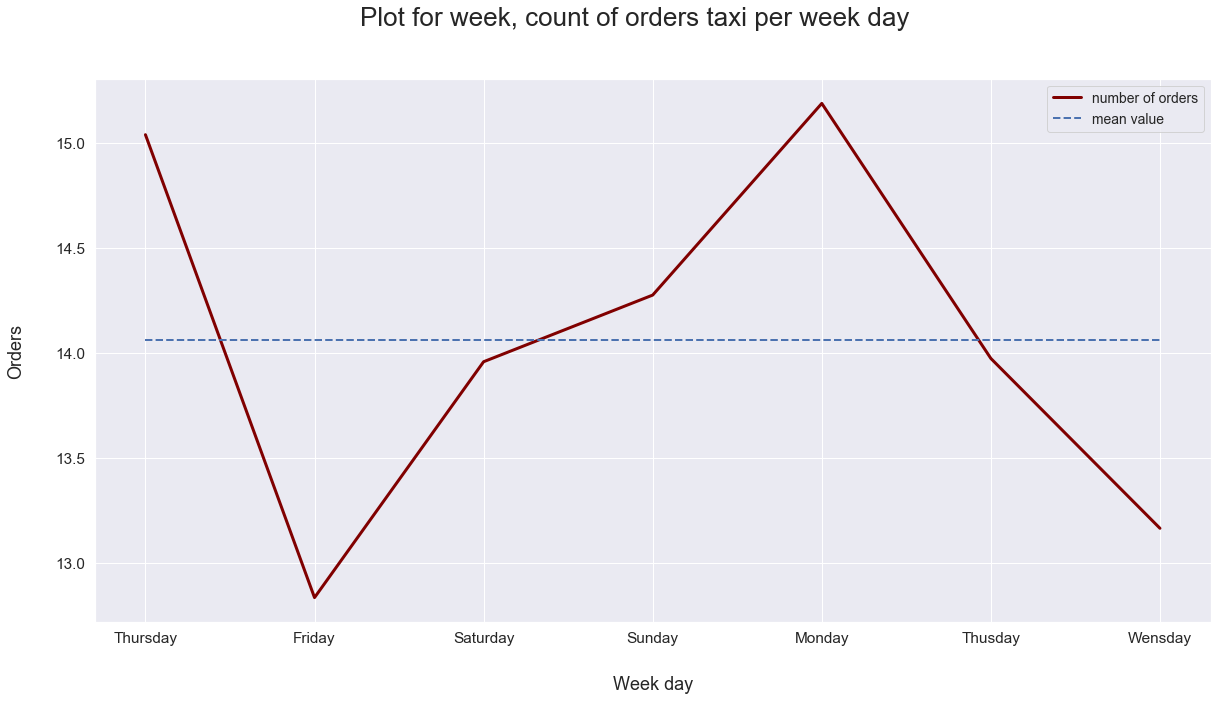

In [9]:
sns.set(font_scale=1.4)

fig = plt.figure(figsize=(20,10))
plt.plot(new_data.pivot_table(index='dayofweek', values='num_orders', aggfunc='mean'), linewidth=3, color='maroon')
plt.plot(range(0, 7, 1), np.ones(7) * new_data.pivot_table(index='dayofweek', values='num_orders', aggfunc='mean').mean()[0], linewidth=2, linestyle='dashed')
fig.suptitle("Plot for week, count of orders taxi per week day", fontsize=26)
plt.legend(["number of orders", "mean value"], fontsize=14)
plt.xlabel("Week day", labelpad=30, fontsize=18)
plt.ylabel("Orders", labelpad=30, fontsize=18)
plt.xticks(np.arange(7), ['Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Thusday', 'Wensday'])


([<matplotlib.axis.XTick at 0x7fbdb14e8a50>,
 <a list of 6 Text xticklabel objects>)

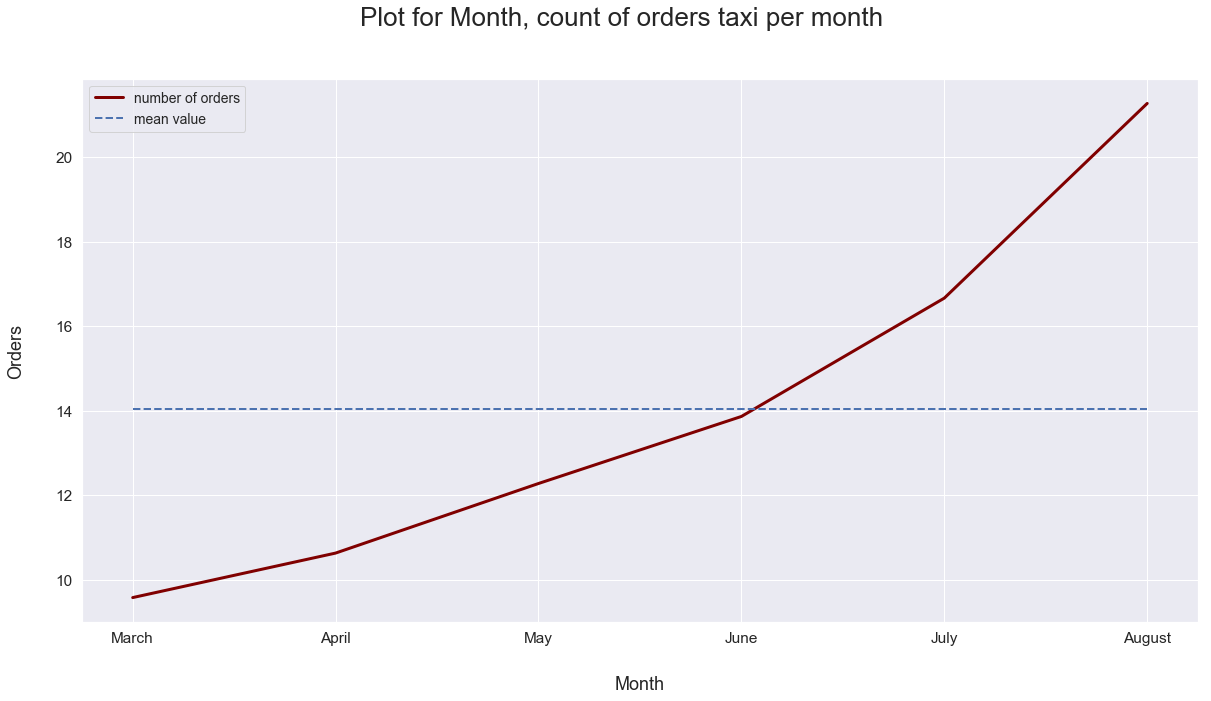

In [10]:
sns.set(font_scale=1.4)

fig = plt.figure(figsize=(20,10))
plt.plot(new_data.pivot_table(index='month', values='num_orders'), linewidth=3, color='maroon')
plt.plot(range(3, 9, 1), np.ones(6) * new_data.pivot_table(index='month', values='num_orders').mean()[0], linewidth=2, linestyle='dashed')
fig.suptitle("Plot for Month, count of orders taxi per month", fontsize=26)
plt.legend(["number of orders", "mean value"], fontsize=14)
plt.xlabel("Month", labelpad=30, fontsize=18)
plt.ylabel("Orders", labelpad=30, fontsize=18)
plt.xticks(np.arange(3, 9, 1), ['March', 'April', 'May', 'June', 'July', 'August'])


In [11]:
decomposed = seasonal_decompose(data.resample('1D').mean())


Text(0, 0.5, 'Orders')

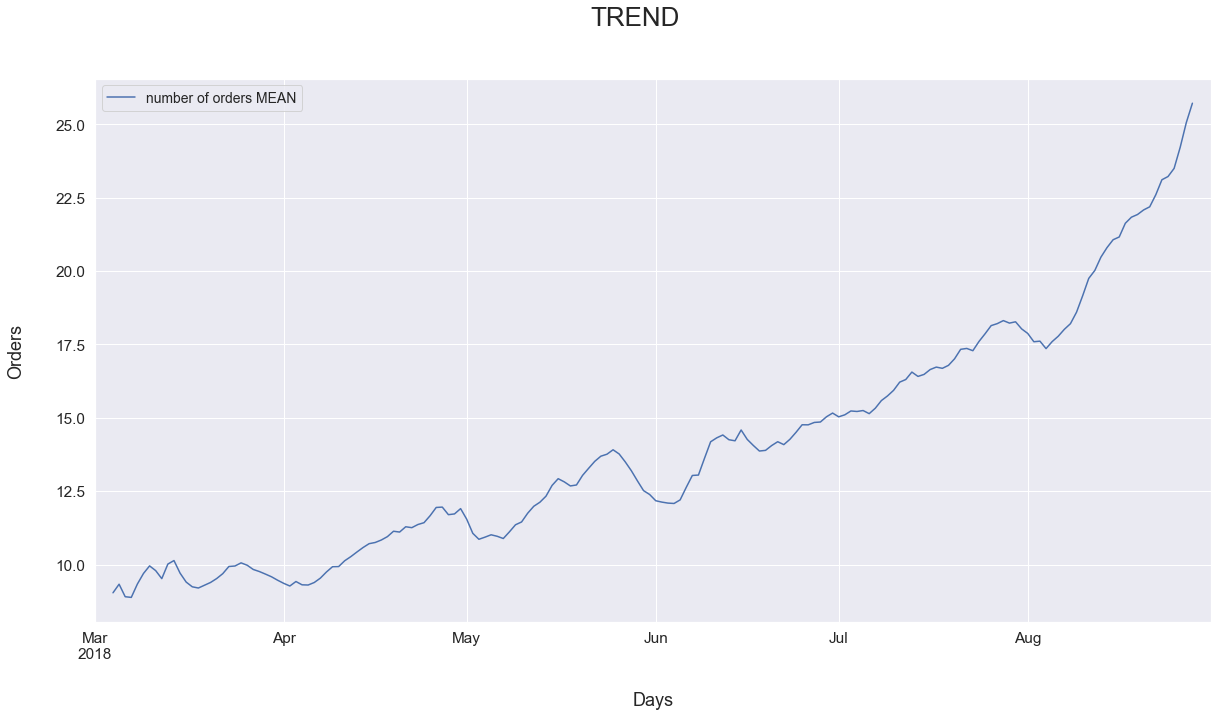

In [12]:
sns.set(font_scale=1.4)

fig = plt.figure(figsize=(20,10))
decomposed.trend['num_orders'].plot()
fig.suptitle("TREND", fontsize=26)
plt.legend(["number of orders MEAN"], fontsize=14)
plt.xlabel("Days", labelpad=30, fontsize=18)
plt.ylabel("Orders", labelpad=30, fontsize=18)


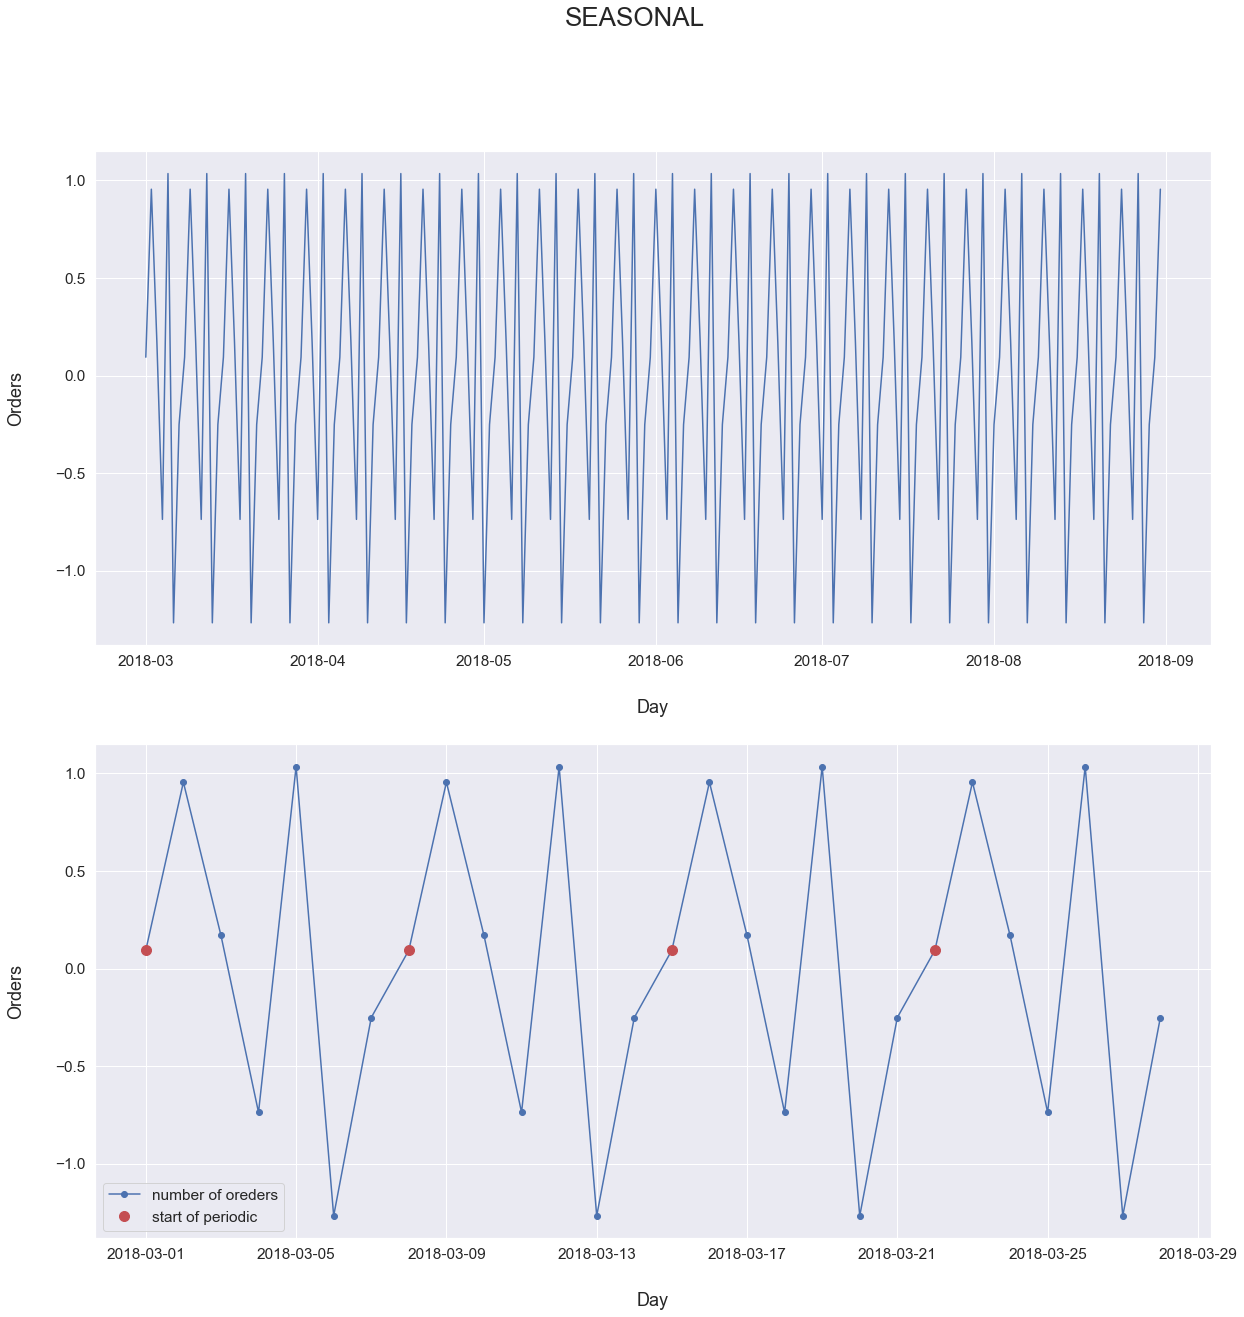

In [13]:
sns.set(font_scale=1.4)

fig, ax = plt.subplots(2, figsize=(20,20))
fig.suptitle("SEASONAL", fontsize=26)

ax[0].plot(decomposed.seasonal['num_orders'])
ax[0].set_xlabel("Day", labelpad=30, fontsize=18)
ax[0].set_ylabel("Orders", labelpad=30, fontsize=18)


ax[1].plot(decomposed.seasonal['num_orders'][:28], marker='o')
ax[1].plot(decomposed.seasonal['num_orders'][::7][:4], 'ro', markersize=10)
ax[1].set_xlabel("Day", labelpad=30, fontsize=18)
ax[1].set_ylabel("Orders", labelpad=30, fontsize=18)
ax[1].legend(['number of oreders', 'start of periodic'])




Text(0, 0.5, 'Orders')

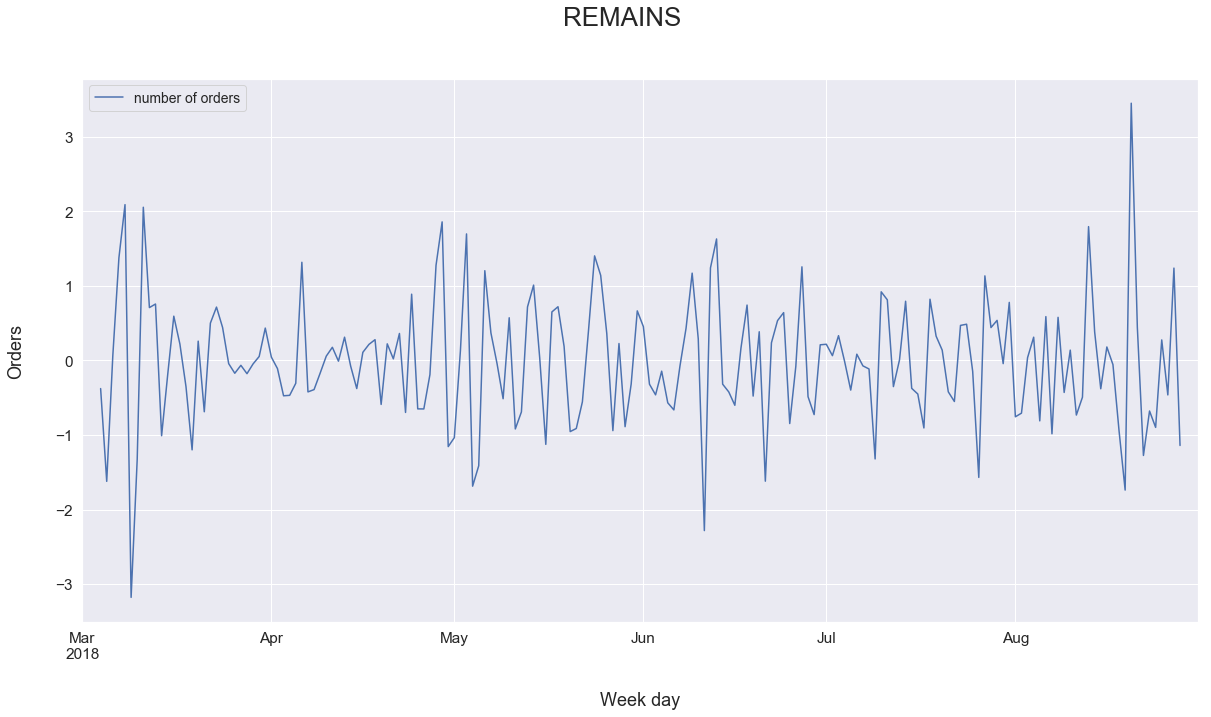

In [14]:
sns.set(font_scale=1.4)

fig = plt.figure(figsize=(20,10))
decomposed.resid['num_orders'].plot()
fig.suptitle("REMAINS", fontsize=26)
plt.legend(["number of orders", "mean value"], fontsize=14)
plt.xlabel("Week day", labelpad=30, fontsize=18)
plt.ylabel("Orders", labelpad=30, fontsize=18)


# 3. Training and Testing

In [15]:
new_data_for_train = new_data.copy()
new_data_for_train['rolling_mean'] = new_data_for_train['num_orders'].shift().rolling(5).mean()

for i in range(1, 7):
    name_of_column = 'lag_' + str(i) 
    new_data_for_train[name_of_column] = new_data_for_train['num_orders'].shift(i)
    
new_data_for_train = new_data_for_train.dropna()
new_data_for_train

,num_orders,dayofweek,hour,month,rolling_mean,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6
datetime,,,,,,,,,,,
2018-03-01 06:00:00,2.000000,3,6,3,9.033333,1.000000,7.166667,11.000000,11.833333,14.166667,20.666667
2018-03-01 07:00:00,2.500000,3,7,3,6.600000,2.000000,1.000000,7.166667,11.000000,11.833333,14.166667
2018-03-01 08:00:00,5.666667,3,8,3,4.733333,2.500000,2.000000,1.000000,7.166667,11.000000,11.833333
2018-03-01 09:00:00,11.500000,3,9,3,3.666667,5.666667,2.500000,2.000000,1.000000,7.166667,11.000000
2018-03-01 10:00:00,10.666667,3,10,3,4.533333,11.500000,5.666667,2.500000,2.000000,1.000000,7.166667
...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,22.666667,4,19,8,29.000000,34.500000,36.166667,32.833333,19.333333,22.166667,27.666667
2018-08-31 20:00:00,25.666667,4,20,8,29.100000,22.666667,34.500000,36.166667,32.833333,19.333333,22.166667
2018-08-31 21:00:00,26.500000,4,21,8,30.366667,25.666667,22.666667,34.500000,36.166667,32.833333,19.333333


In [16]:
features = new_data_for_train.drop('num_orders', 1)
target = new_data_for_train['num_orders']

In [17]:
features_train, features_test, target_train, target_test = train_test_split(features, target, shuffle=False, test_size=0.1)


### LinearRegressor

In [18]:
model = LinearRegression()
model.fit(features_train, target_train)
predicted_value = model.predict(features_test)

print(mean_squared_error(target_test, predicted_value) ** 0.5)

9.272497928158998


### RandomForest

In [38]:
model = RandomForestRegressor()
model.fit(features_train, target_train)
predicted_value = model.predict(features_test)

print(mean_squared_error(target_test, predicted_value) ** 0.5)

7.9183735678286595


/Users/gleb/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [69]:
param_grid_total={'n_estimators': range(40, 71, 10),
            'max_depth': range(5,16,2),
            'min_samples_split': range(2,100,20),
            'min_samples_leaf': range(1,30,10),
            'max_features':range(3,10,2)}

In [71]:
model = RandomForestRegressor(n_estimators=100)

clf = GridSearchCV(model, scoring="neg_mean_squared_error", param_grid=param_grid_total, n_jobs=4, cv=5)
clf.fit(features_train, target_train)

clf.best_estimator_

/Users/gleb/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=22,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [79]:
param_grid_total={'max_depth': range(5,20,2),
                  'max_features':range(2,11,2)}

In [80]:
model = RandomForestRegressor(min_samples_leaf=1, min_samples_split=22, n_estimators=100, )

clf = GridSearchCV(model, scoring="neg_mean_squared_error", param_grid=param_grid_total, n_jobs=4, cv=5)
clf.fit(features_train, target_train)

clf.best_estimator_

/Users/gleb/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=17,
                      max_features=10, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=22,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [81]:
param_grid_total={'n_estimators': range(200,2001,300)}

In [82]:
model = RandomForestRegressor(max_depth=17, min_samples_leaf=1, min_samples_split=22, max_features=10)

clf = GridSearchCV(model, scoring="neg_mean_squared_error", param_grid=param_grid_total, n_jobs=4, cv=5)
clf.fit(features_train, target_train)

clf.best_estimator_

/Users/gleb/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=17,
                      max_features=10, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=22,
                      min_weight_fraction_leaf=0.0, n_estimators=500,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [66]:
model = RandomForestRegressor(max_depth=17, min_samples_leaf=1, min_samples_split=22, max_features=10)
model.fit(features_train, target_train)
predicted_value = model.predict(features_test)

print(mean_squared_error(target_test, predicted_value) ** 0.5)

8.302930124938658


/Users/gleb/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


### GradientBoostingRegressor

In [26]:
model = GradientBoostingRegressor()
model.fit(features_train, target_train)
predicted_value = model.predict(features_test)

print(mean_squared_error(target_test, predicted_value) ** 0.5)

8.166336129526826


### CatBoostRegressor

In [19]:
model = CatBoostRegressor()

grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9],
        'iterations': [100, 1000],
        'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}

grid_search_result = model.randomized_search(grid, X=features_train, y=target_train, verbose=False, plot=True, shuffle=False)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 5.214840294
bestIteration = 534


bestTest = 5.464807549
bestIteration = 98


bestTest = 5.365437774
bestIteration = 401


bestTest = 5.280155339
bestIteration = 807


bestTest = 7.538754129
bestIteration = 99


bestTest = 5.797928034
bestIteration = 305


bestTest = 5.267154891
bestIteration = 497


bestTest = 7.118875555
bestIteration = 99


bestTest = 7.601134367
bestIteration = 99


bestTest = 5.840954601
bestIteration = 757



In [20]:
grid_search_result['params']

{'depth': 4,
 'l2_leaf_reg': 7,
 'iterations': 1000,
 'subsample': 0.7,
 'learning_rate': 0.1}

In [23]:
model = CatBoostRegressor(depth=4, l2_leaf_reg=7, iterations=1000, subsample=0.7, learning_rate=0.1, verbose=False)

model.fit(features_train, target_train)

predicted_value = model.predict(features_test)

score = mean_squared_error(predicted_value, target_test) ** 0.5
print(score)

8.12186783420588
